# Pandas - spojování tabulek a vztahy mezi proměnnými

Tato lekce se nese ve znamení mnohosti a propojování - naučíš se:

- pracovat s více tabulkami najednou
- nacházet spojitosti mezi dvěma (a více) proměnnými

Při tom společně projdeme (ne poprvé a ne naposledy) čištění reálných datových sad.

In [68]:
# Importy jako obvykle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Spojování tabulek

V lekci, kde jsme zpracovávali data o počasí, jsme ti ukázali, že je pomocí funkce `concat` možné slepit dohromady několik objektů `DataFrame` či `Series`, pokud mají "kompatibilní" index. Nyní se na problematiku podíváme trochu blíže a ukážeme si, jak spojovat tabulky na základě různých sloupců, a co dělat, když řádky z tabulky jedné nepasují přesně na tabulku druhou.

Obecně pro spojování `pandas` nabízí čtyři funkce / metody:

- `concat` je univerzální funkce pro slepování dvou či více tabulek / sloupců - pod sebe, vedle sebe, s přihlédnutím k indexům i bez něj. 
- `append` (metoda) zjednodušuje práci s `concat`, pokud jen chceš do nějaké tabulky přidat pár řádků.
- `merge` je univerzální funkce pro spojování tabulek na základě vazby mezi indexy nebo sloupci.
- `join` (metoda) zjednodušuje práci, když chceš spojit dvě tabulky na základě indexu.

Detailní rozbor toho, co která umí, najdeš v [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html). Mnoho věcí lze udělat použitím dvou (nebo i tří) z výše
uvedených možností.

### Jednoduché skládání

To je asi ten nejjednodušší případ - máme dva objekty `Series` nebo dva kusy tabulky se stejnými sloupci a chceme je spojit pod sebou. Protože použití `append` a `concat` jsou velice podobná, ukážeme si je bez většího halasu hned obě najednou:

In [74]:
a = pd.Series([1, 2, 3])
b = pd.Series([4, 5, 6])

In [75]:
a.append(b)

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

💡 Vidíš, že se index opakuje? Vytvořili jsme dvě `Series`, u kterých jsme index neřešili. Jenže `pandas` na rozdíl od nás ano, a tak poslušně oba indexy spojil, i za cenu duplicitních hodnot. Za cenu použití dodatečného argumentu `ignore_index=True` se tomu lze vyhnout, což si ukážeme na příklady spojování dvou tabulek o stejných sloupcích:

In [80]:
df1 = pd.DataFrame({
    "levy": [1, 2],
    "pravy": [3, 4]
})
df2 = pd.DataFrame({
    "levy": [25, 26],
    "pravy": [47, 48]
})
df1.append(df2, ignore_index=True)

,levy,pravy
0,1,3
1,2,4
2,25,47
3,26,48


Totéž s použitím `concat`:

In [5]:
pd.concat([a, b])

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

In [6]:
pd.concat(1000 * [a], ignore_index=True)

0       1
1       2
2       3
3       1
4       2
       ..
2995    2
2996    3
2997    1
2998    2
2999    3
Length: 3000, dtype: int64

Když chceme "lepit" doprava (třeba deset `Series`), stačí přidat nám dobře známý argument `axis`:

In [86]:
pd.concat([a] * 10, axis="columns")

,0,1,2,3,4,5,6,7,8,9
0,1,1,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2,2,2,2
2,3,3,3,3,3,3,3,3,3,3


**Příklad:** Jak co nejrychleji "nakreslit" "šachovnici" (obě slova jsou v uvozovkách) z číslic 0 a 1?

In [87]:
sachy = pd.concat(
    [
        pd.concat(   
            [pd.DataFrame([[0, 1], [1, 0]])] * 4,
            axis=1)
    ] * 4)
sachy.index = list(range(1, 9))
sachy.columns = list("ABCDEFGH")
sachy

,A,B,C,D,E,F,G,H
1,0,1,0,1,0,1,0,1
2,1,0,1,0,1,0,1,0
3,0,1,0,1,0,1,0,1
4,1,0,1,0,1,0,1,0
5,0,1,0,1,0,1,0,1
6,1,0,1,0,1,0,1,0
7,0,1,0,1,0,1,0,1
8,1,0,1,0,1,0,1,0


### Spojování různorodých tabulek

🎦 Pro spojování heterogenních dat (v datové hantýrce "joinování") sáhneme po trochu komplexnějších filmových datech...

Data jsou veliká. Úmyslně veliká. Jsou tak veliká, že ti je nemůžeme naservírovat na stříbrném podnose (leda bys sebou takový podnos měl/a a na něm ležela flashka - na tu ti je můžeme nahrát). Nabízí se dvě možnosti, jak je můžeš získat:

**Alternativa 1.** Stáhni si manuálně do aktuálního adresáře následující soubory:

- https://datasets.imdbws.com/title.basics.tsv.gz
- https://datasets.imdbws.com/title.ratings.tsv.gz
- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/rotten_tomatoes_top_movies_2019-01-15.csv
- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/boxoffice_march_2019.csv.gz

**Alternativa 2:** Pusť si (ideálně ještě doma, před hodinou) následující kód, který stáhne všechny potřebné soubory. Navíc to učiní pouze jednou, opětovné volání už nic dalšího nestahuje.

<div style="color: red; background: yellow">Vyřešit, odkud budeme data brát, jsou to stovky MB a navíc není jasné, jak moc legální je mít je lokálně uložená.</div>

In [9]:
# Nutné importy ze standardní knihovny
import os
from urllib.request import urlopen

# Seznam souborů (viz níže)
zdroje = [
    "https://datasets.imdbws.com/title.basics.tsv.gz",
    "https://datasets.imdbws.com/title.ratings.tsv.gz",
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/rotten_tomatoes_top_movies_2019-01-15.csv",
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/boxoffice_march_2019.csv.gz"
]

for url in zdroje:
    # Pouze poslední část cesty adresy datového zdroje je jeho jméno
    jmeno = url.rsplit("/")[-1]
    
    if not os.path.exists(jmeno):        
        print(f"Soubor {jmeno} ještě není stažen, jdeme na to...")
        
        # Sendvičově otevřeme výstup (soubor na disku) i vstup (webovou stránku)
        with open(jmeno, "wb") as outfile:  # Pozor - binární mód
            with urlopen(url) as inpage:
                # A jen přepíšeme obsah 
                outfile.write(inpage.read())
        print(f"Soubor {jmeno} úspěšně stažen.")
    else:
        print(f"Soubor {jmeno} už byl stažen, použijeme místní kopii.")

Soubor title.basics.tsv.gz už byl stažen, použijeme místní kopii.
Soubor title.ratings.tsv.gz už byl stažen, použijeme místní kopii.
Soubor rotten_tomatoes_top_movies_2019-01-15.csv už byl stažen, použijeme místní kopii.
Soubor boxoffice_march_2019.csv.gz už byl stažen, použijeme místní kopii.


**Hotovo? :-)**

Máme staženo několik souborů, načteme si je (zatím hrubě, "raw") - s přihlédnutím k tomu, že první dva nejsou v pravém slova smyslu "comma-separated", ale používají k oddělení hodnot tabulátor (tady pomůže argument `sep`). Také zohledníme, že v nich řetězec "\N" představuje chybějící hodnoty (pomůže argument `na_values`):

In [91]:
imdb_titles_raw = pd.read_csv('title.basics.tsv.gz', sep='\t', na_values="\\N")
imdb_ratings_raw = pd.read_csv('title.ratings.tsv.gz', sep='\t', na_values="\\N")
boxoffice_raw = pd.read_csv('boxoffice_march_2019.csv.gz')
rotten_tomatoes_raw = pd.read_csv("rotten_tomatoes_top_movies_2019-01-15.csv")

C:\Users\janpi\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



Co který soubor obsahuje? 

- První dva soubory obsahují volně dostupná (byť "jen" pro nekomerční použití) data o filmech z IMDB (Internet Movie Database). My jsme si zvolili obecné informace a uživatelská (číselná) hodnocení. Detailní popis souborů, stejně jako odkazy na další soubory, najdeš na https://www.imdb.com/interfaces/.

- DOPLNIT 

- DOPLNIT https://www.rottentomatoes.com/

Pojďme se podívat na nedostatky těchto souborů a postupně je skládat dohromady. Zajímalo by nás (a snad i tebe!), jak souvisí hodnocení s komerční úspěšností filmu, jak se liší hodnocení rotten tomatoes od těch na IMDB.

In [117]:
imdb_titles_raw

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
6419875,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010.0,NaN,NaN,"Action,Drama,Family"
6419876,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010.0,NaN,NaN,"Action,Drama,Family"
6419877,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010.0,NaN,NaN,"Action,Drama,Family"
6419878,tt9916856,short,The Wind,The Wind,0,2015.0,NaN,27,Short


In [92]:
imdb_titles_raw.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear         float64
endYear           float64
runtimeMinutes     object
genres             object
dtype: object

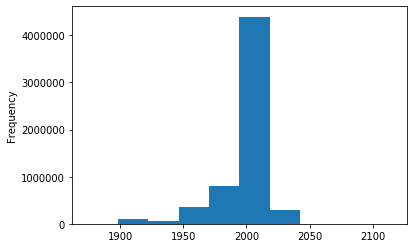

In [14]:
# Filmy z budoucnosti!
imdb_titles_raw["startYear"].plot.hist()

In [15]:
# Očividně někdo zapisoval hodnoty, kam neměl
imdb_titles_raw["isAdult"].value_counts()

0       6226822
1        193047
2019          4
2020          1
2018          1
2015          1
2014          1
2005          1
2004          1
1994          1
Name: isAdult, dtype: int64

In [113]:
imdb_titles_corrected = (
    imdb_titles_raw
    .query("startYear <= 2019")             # Vyhodí budoucnost i nevyplněné
    .query("isAdult <= 1")                  # Chybně vyplněné řádky       
)

In [118]:
imdb_titles_converted = (
    imdb_titles_corrected
    .assign(
        titleType=imdb_titles_corrected["titleType"].astype("category"),
        startYear=imdb_titles_corrected["startYear"].astype(int),
        isAdult=imdb_titles_corrected["isAdult"].astype(bool),
        runtimeMinutes=pd.to_numeric(imdb_titles_corrected["runtimeMinutes"], errors="coerce").astype("Int32")
    )
)

In [150]:
imdb_titles = (
    imdb_titles_converted
    .dropna(subset=["runtimeMinutes"])
    .rename({
        "primaryTitle": "title",
        "originalTitle": "original_title",
        "titleType": "title_type",
        "runtimeMinutes": "length",
        "startYear": "start_year",
        "endYear": "end_year",
        "isAdult": "is_adult",
    }, axis="columns")
    .set_index("tconst")
    #.sort_values(["start_year", "title"])
)
imdb_titles

,title_type,title,original_title,is_adult,start_year,end_year,length,genres
tconst,,,,,,,,
tt0000001,short,Carmencita,Carmencita,False,1894,NaN,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,False,1892,NaN,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,False,1892,NaN,4,"Animation,Comedy,Romance"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,False,1893,NaN,1,"Comedy,Short"
tt0000006,short,Chinese Opium Den,Chinese Opium Den,False,1894,NaN,1,Short
...,...,...,...,...,...,...,...,...
tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,False,2013,NaN,49,Documentary
tt9916766,tvEpisode,Episode #10.15,Episode #10.15,False,2019,NaN,43,"Family,Reality-TV"
tt9916840,tvEpisode,Horrid Henry's Comic Caper,Horrid Henry's Comic Caper,False,2014,NaN,11,"Animation,Comedy,Family"


In [151]:
# Nejenom filmy, ale i mraky epizod a drobných děl
imdb_titles["title_type"].value_counts()

tvEpisode       701882
short           457109
movie           335162
video           175455
tvMovie          77967
tvSeries         74597
tvSpecial        12940
tvMiniSeries     11200
tvShort          10508
videoGame          166
Name: title_type, dtype: int64

In [152]:
movies = (
    imdb_titles
    .query("title_type == 'movie'")
    .drop(["title_type", "end_year"], axis="columns")
    .rename({"start_year": "year"}, axis="columns")
)
movies

,title,original_title,is_adult,year,length,genres
tconst,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport"
tt0000502,Bohemios,Bohemios,False,1905,100,NaN
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama"
tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,False,1908,120,"Adventure,Fantasy"
...,...,...,...,...,...,...
tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,False,2019,123,Drama
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,False,2015,57,Documentary
tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,False,2007,100,Documentary


In [153]:
print(movies.shape)
print(movies.dtypes)

(335162, 6)
title             object
original_title    object
is_adult            bool
year               int32
length             Int32
genres            object
dtype: object


In [154]:
imdb_ratings_raw

,tconst,averageRating,numVotes
0,tt0000001,5.6,1561
1,tt0000002,6.1,188
2,tt0000003,6.5,1225
3,tt0000004,6.1,114
4,tt0000005,6.1,1958
...,...,...,...
1006167,tt9916576,5.9,7
1006168,tt9916578,9.2,12
1006169,tt9916720,5.3,44
1006170,tt9916766,6.7,11


In [155]:
imdb_ratings_raw.dtypes

tconst            object
averageRating    float64
numVotes           int64
dtype: object

In [156]:
ratings = (imdb_ratings_raw
    .rename({
        "averageRating": "imdb_rating",
        "numVotes": "imdb_votes"
    }, axis="columns")
    .set_index("tconst")
)
ratings

,imdb_rating,imdb_votes
tconst,,
tt0000001,5.6,1561
tt0000002,6.1,188
tt0000003,6.5,1225
tt0000004,6.1,114
tt0000005,6.1,1958
...,...,...
tt9916576,5.9,7
tt9916578,9.2,12
tt9916720,5.3,44


Máme připravené dvě krásné tabulky, které sdílejí stejný index, a můžeme vesele spojovat. Protože pomocí `join`, `merge` a `concat` lze volbou vhodných parametrů dosáhnout identického výsledku (což je jedním z nešvarů knihovny `pandas`), ukážeme si všechny tři alternativy podle subjektivního pořadí vhodnosti. A úplně nakonec si ukážeme, jak by to šlo, ale rozhodně by se dělat nemělo!

In [157]:
movies.join(ratings)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.4,84.0
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,316.0
tt0000502,Bohemios,Bohemios,False,1905,100,NaN,NaN,NaN
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.1,542.0
tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,False,1908,120,"Adventure,Fantasy",4.8,32.0
...,...,...,...,...,...,...,...,...
tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,False,2019,123,Drama,NaN,NaN
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,False,2015,57,Documentary,NaN,NaN
tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,False,2007,100,Documentary,NaN,NaN


In [172]:
for how in ["left", "right", "inner", "outer"]:
    print(how, movies.join(ratings, how=how).shape)

left (335162, 8)
right (1006172, 8)
inner (215507, 8)
outer (1125827, 8)


In [ ]:
# Alternativa 1 (preferovaná)
movies.join(ratings, how="inner")

In [ ]:
# Alternativa 2 (dobrá)
pd.merge(movies, ratings, left_index=True, right_index=True, how="inner")

In [ ]:
# Alternativa 3 (méně vhodná)
pd.concat([movies, ratings], axis="columns", join="inner")

In [ ]:
# Alternativa 4 (ok, tahle JE špatná)!
# Omezíme se na začátek tabulky, nebo nám dojde paměť

# `append` vkládá jen pod sebe, tak si tabulky otočíme!
df1 = movies[:6].T   
df2 = ratings.T
(
    df1.append(df2)      # Sloučíme "řádky"
    .T                   # Otočíme zpátky
    .dropna(             # Vyhodíme nepasující (emulace "inner")
        subset=["title", "imdb_rating"]
    )
)

# Začátek tabulky sedí!

Zkusme si zreprodukovat pořadí 250 nejlepších filmů z IMDB (viz https://www.imdb.com/chart/top/?ref_=nv_mv_250):

In [24]:
movies_with_rating = movies.join(ratings, how="inner")

# Totéž (a navíc stejně rychle):
# movies_with_rating = pd.merge(movies, ratings, left_index=True, right_index=True, how="inner")

# Ty nejlepší:
(movies_with_rating
    .query("imdb_votes > 25000")
    .sort_values("imdb_rating", ascending=False)
    .reset_index(drop=True)
).head(30)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
0,The Chaos Class,Hababam Sinifi,False,1975,87,"Comedy,Drama",9.4,34670
1,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2172577
2,The Godfather,The Godfather,False,1972,175,"Crime,Drama",9.2,1496722
3,CM101MMXI Fundamentals,CM101MMXI Fundamentals,False,2013,139,"Comedy,Documentary",9.2,42245
4,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2156729
5,The Godfather: Part II,The Godfather: Part II,False,1974,202,"Crime,Drama",9.0,1047873
6,The Mountain II,Dag II,False,2016,135,"Action,Drama,War",9.0,102065
7,12 Angry Men,12 Angry Men,False,1957,96,Drama,8.9,632351
8,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,False,2003,201,"Adventure,Drama,Fantasy",8.9,1545865
9,Schindler's List,Schindler's List,False,1993,195,"Biography,Drama,History",8.9,1134131


In [25]:
boxoffice_raw

,rank,title,studio,lifetime_gross,year
0,1,Star Wars: The Force Awakens,BV,936662225,2015
1,2,Avatar,Fox,760507625,2009
2,3,Black Panther,BV,700059566,2018
3,4,Avengers: Infinity War,BV,678815482,2018
4,5,Titanic,Par.,659363944,1997
...,...,...,...,...,...
16262,16263,Dog Eat Dog,IFC,80,2009
16263,16264,Paranoid Girls,NaN,78,2015
16264,16265,Confession of a Child of the Century,Cohen,74,2015
16265,16266,Storage 24,Magn.,72,2013


In [26]:
boxoffice_raw.dtypes

rank               int64
title             object
studio            object
lifetime_gross     int64
year               int64
dtype: object

In [27]:
boxoffice = (boxoffice_raw
    .rename({
        "rank": "boxoffice_rank"
    }, axis="columns")
)

In [28]:
movies_with_rating_and_boxoffice_beta = pd.merge(
    movies_with_rating,
    boxoffice,
    on=["title"]
)
movies_with_rating_and_boxoffice_beta.query("title == 'Pinocchio'")

#TODO: validate="one_to_one"

,title,original_title,is_adult,year_x,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,year_y
0,Pinocchio,Pinocchio,False,1911,50,Fantasy,5.8,75,885,Dis.,84254167,1940
1,Pinocchio,Pinocchio,False,1911,50,Fantasy,5.8,75,6108,Mira.,3684305,2002
2,Pinocchio,Pinocchio,False,1940,88,"Animation,Comedy,Family",7.4,121153,885,Dis.,84254167,1940
3,Pinocchio,Pinocchio,False,1940,88,"Animation,Comedy,Family",7.4,121153,6108,Mira.,3684305,2002
4,Pinocchio,Turlis Abenteuer,False,1967,75,"Adventure,Family,Fantasy",7.3,21,885,Dis.,84254167,1940
5,Pinocchio,Turlis Abenteuer,False,1967,75,"Adventure,Family,Fantasy",7.3,21,6108,Mira.,3684305,2002
6,Pinocchio,Pinocchio,False,1971,74,"Comedy,Fantasy",3.6,130,885,Dis.,84254167,1940
7,Pinocchio,Pinocchio,False,1971,74,"Comedy,Fantasy",3.6,130,6108,Mira.,3684305,2002
8,Pinocchio,Un burattino di nome Pinocchio,False,1971,96,"Animation,Family,Fantasy",6.8,125,885,Dis.,84254167,1940
9,Pinocchio,Un burattino di nome Pinocchio,False,1971,96,"Animation,Family,Fantasy",6.8,125,6108,Mira.,3684305,2002


In [29]:
movies_with_rating_and_boxoffice = (
    pd.merge(
        movies_with_rating,
        boxoffice,
        # left_on=["primaryTitle", "startYear"],
        on=["title", "year"]
    )
)
movies_with_rating_and_boxoffice.query("title == 'Pinocchio'")

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
9,Pinocchio,Pinocchio,False,1940,88,"Animation,Comedy,Family",7.4,121153,885,Dis.,84254167
4134,Pinocchio,Pinocchio,False,2002,108,"Comedy,Family,Fantasy",4.3,7356,6108,Mira.,3684305


In [30]:
movies_with_rating_and_boxoffice.sort_values("lifetime_gross", ascending=False).head(10)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
5903,Avatar,Avatar,False,2009,162,"Action,Adventure,Fantasy",7.8,1071483,2,Fox,760507625
8723,Black Panther,Black Panther,False,2018,134,"Action,Adventure,Sci-Fi",7.3,557072,3,BV,700059566
8702,Avengers: Infinity War,Avengers: Infinity War,False,2018,149,"Action,Adventure,Sci-Fi",8.5,734676,4,BV,678815482
3135,Titanic,Titanic,False,1997,194,"Drama,Romance",7.8,985670,5,Par.,659363944
7748,Jurassic World,Jurassic World,False,2015,124,"Action,Adventure,Sci-Fi",7.0,552577,6,Uni.,652270625
8814,Incredibles 2,Incredibles 2,False,2018,118,"Action,Adventure,Animation",7.7,221921,9,BV,608581744
5813,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2156729,10,WB,535234033
8176,Rogue One: A Star Wars Story,Rogue One,False,2016,133,"Action,Adventure,Sci-Fi",7.8,506672,11,BV,532177324
8030,Finding Dory,Finding Dory,False,2016,97,"Adventure,Animation,Comedy",7.3,222125,13,BV,486295561
3492,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,False,1999,136,"Action,Adventure,Fantasy",6.5,680555,14,Fox,474544677


In [31]:
movies_with_rating[movies_with_rating["title"].str.startswith("Star Wars:")].sort_values("year", ascending=False)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt2527338,Star Wars: Episode IX - The Rise of Skywalker,Star Wars: Episode IX - The Rise of Skywalker,False,2019,142,"Action,Adventure,Fantasy",7.0,159507
tt9548962,Star Wars: The Fans Vs Disney,Star Wars: The Fans Vs Disney,False,2018,57,Documentary,9.0,46
tt2527336,Star Wars: Episode VIII - The Last Jedi,Star Wars: Episode VIII - The Last Jedi,False,2017,151,"Action,Adventure,Fantasy",7.1,504356
tt7421764,Star Wars: Rise of the First Order,Star Wars: Rise of the First Order,False,2017,87,"Action,Drama",5.5,8
tt5957180,Star Wars: The Dark Reckoning,Star Wars: The Dark Reckoning,False,2017,45,Sci-Fi,5.8,12
tt2488496,Star Wars: Episode VII - The Force Awakens,Star Wars: Episode VII - The Force Awakens,False,2015,138,"Action,Adventure,Sci-Fi",7.9,813070
tt2275656,Star Wars: Threads of Destiny,Star Wars: Threads of Destiny,False,2014,110,"Action,Adventure,Sci-Fi",4.0,490
tt1432993,Star Wars: A Galaxy in Darkness,Star Wars: A Galaxy in Darkness,False,2009,46,"Adventure,Animation,Drama",5.2,22
tt1185834,Star Wars: The Clone Wars,Star Wars: The Clone Wars,False,2008,98,"Action,Adventure,Animation",5.9,52157


In [32]:
rotten_tomatoes_raw

,Rank,Title,RatingTomatometer,No. of Reviews,Genres
0,1,Black Panther (2018),97,444,action|adventure
1,2,Mad Max: Fury Road (2015),97,394,action|adventure
2,3,Wonder Woman (2017),93,410,action|adventure
3,4,Metropolis (1927),99,118,action|adventure
4,5,Coco (2017),97,308,action|adventure
...,...,...,...,...,...
1585,70,Priest (2011),15,97,western
1586,71,American Outlaws (2001),14,103,western
1587,72,September Dawn (2007),15,54,western
1588,73,Jonah Hex (2010),12,147,western


In [33]:
rotten_tomatoes_raw["Title"].value_counts()

Yellow Submarine (1968)                                 6
Harry Potter and the Deathly Hallows - Part 2 (2011)    5
101 Dalmatians (1961)                                   5
Afghan Star (2009)                                      5
Who Framed Roger Rabbit (1988)                          5
                                                       ..
Won't You Be My Neighbor? (2018)                        1
Open Hearts (Elsker Dig For Evigt) (2002)               1
The House of the Devil (2009)                           1
Goodnight Mommy (Ich seh, Ich seh) (2015)               1
Five Easy Pieces (1970)                                 1
Name: Title, Length: 947, dtype: int64

In [34]:
rotten_tomatoes_raw.drop_duplicates(subset=["Title"])

,Rank,Title,RatingTomatometer,No. of Reviews,Genres
0,1,Black Panther (2018),97,444,action|adventure
1,2,Mad Max: Fury Road (2015),97,394,action|adventure
2,3,Wonder Woman (2017),93,410,action|adventure
3,4,Metropolis (1927),99,118,action|adventure
4,5,Coco (2017),97,308,action|adventure
...,...,...,...,...,...
1585,70,Priest (2011),15,97,western
1586,71,American Outlaws (2001),14,103,western
1587,72,September Dawn (2007),15,54,western
1588,73,Jonah Hex (2010),12,147,western


In [35]:
rotten_tomatoes_beta = (rotten_tomatoes_raw
    .drop_duplicates(subset=["Title"])
    .assign(
        title=lambda df: df["Title"].str.slice(0, -7),
        year=lambda df: df["Title"].str.slice(-5, -1).astype(int)
    )
    .drop_duplicates(subset=["Title"])
    .rename({
        "RatingTomatometer": "tomatoes_rating",
        "No. of Reviews": "tomatoes_votes",
    }, axis="columns")
    .drop(["Title", "Rank", "Genres"], axis="columns")
)
rotten_tomatoes_beta

,tomatoes_rating,tomatoes_votes,title,year
0,97,444,Black Panther,2018
1,97,394,Mad Max: Fury Road,2015
2,93,410,Wonder Woman,2017
3,99,118,Metropolis,1927
4,97,308,Coco,2017
...,...,...,...,...
1585,15,97,Priest,2011
1586,14,103,American Outlaws,2001
1587,15,54,September Dawn,2007
1588,12,147,Jonah Hex,2010


In [36]:
rotten_tomatoes = (rotten_tomatoes_beta
    .assign(
        title=rotten_tomatoes_beta["title"].str.rsplit("(", 1).apply(lambda x: x[0])
    )
)
rotten_tomatoes

,tomatoes_rating,tomatoes_votes,title,year
0,97,444,Black Panther,2018
1,97,394,Mad Max: Fury Road,2015
2,93,410,Wonder Woman,2017
3,99,118,Metropolis,1927
4,97,308,Coco,2017
...,...,...,...,...
1585,15,97,Priest,2011
1586,14,103,American Outlaws,2001
1587,15,54,September Dawn,2007
1588,12,147,Jonah Hex,2010


In [37]:
rotten_tomatoes.title.value_counts()

True Grit                                       2
Halloween                                       2
The Magnificent Seven                           2
Invasion of the Body Snatchers                  2
Hairspray                                       2
                                               ..
Topsy-Turvy                                     1
Shaun of the Dead                               1
Outfoxed: Rupert Murdoch's War on Journalism    1
Dave                                            1
Bus 174                                         1
Name: title, Length: 942, dtype: int64

In [38]:
movies_complete = pd.merge(
    movies_with_rating_and_boxoffice,
    rotten_tomatoes,
    on=["title", "year"],
    how="inner"
)
movies_complete.sort_values("boxoffice_rank").reset_index(drop=True).head(20)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,tomatoes_rating,tomatoes_votes
0,Black Panther,Black Panther,False,2018,134,"Action,Adventure,Sci-Fi",7.3,557072,3,BV,700059566,97,444
1,Avengers: Infinity War,Avengers: Infinity War,False,2018,149,"Action,Adventure,Sci-Fi",8.5,734676,4,BV,678815482,84,408
2,Titanic,Titanic,False,1997,194,"Drama,Romance",7.8,985670,5,Par.,659363944,89,184
3,Incredibles 2,Incredibles 2,False,2018,118,"Action,Adventure,Animation",7.7,221921,9,BV,608581744,94,332
4,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2156729,10,WB,535234033,94,332
5,Finding Dory,Finding Dory,False,2016,97,"Adventure,Animation,Comedy",7.3,222125,13,BV,486295561,94,309
6,Shrek 2,Shrek 2,False,2004,93,"Adventure,Animation,Comedy",7.2,394696,18,DW,441226247,89,235
7,The Lion King,The Lion King,False,1994,88,"Adventure,Animation,Drama",8.5,877753,22,BV,422783777,93,123
8,Toy Story 3,Toy Story 3,False,2010,103,"Adventure,Animation,Comedy",8.3,711637,24,BV,415004880,98,299
9,Wonder Woman,Wonder Woman,False,2017,141,"Action,Adventure,Fantasy",7.4,511092,25,WB,412563408,93,410


**Smutná poznámka** Tohle obecně nemá řešení.

## Vztahy mezi dvěma proměnnými

Když jsme studovali vlastnosti zemí světa, věnovali jsme se především jednotlivým charakteristikám zvlášť, nanejvýš pak jsme si udělali intuitivní obrázek z bodového grafu ("scatter plot"), kde osy *x* a *y* patřily dvěma různým vlastnostem. Nyní se vztahy mezi více proměnnými budeme zabývat podrobněji a ukážeme si i některé odvážnější vizualizace.

Poznámka: Budeme pokračovat s výše uvedenými filmovými daty (a jejich sloučenými tabulkami), a tak je třeba, abys spustil/a
všechny buňky předcházející této kapitole.

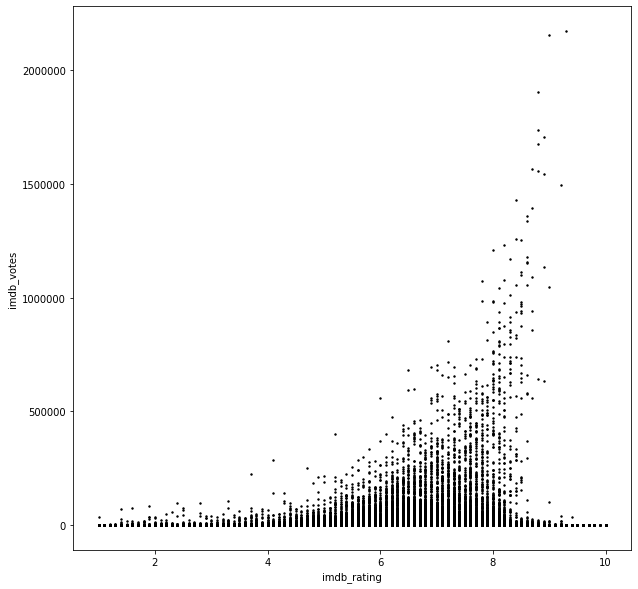

In [72]:
movies_with_rating.plot.scatter("imdb_rating", "imdb_votes", s=2, c="black", figsize=(10, 10))

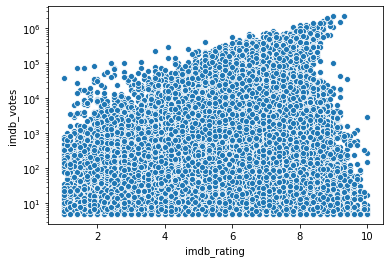

In [40]:
ax = sns.scatterplot(data=movies_with_rating, x="imdb_rating", y="imdb_votes")
ax.set_yscale("log")

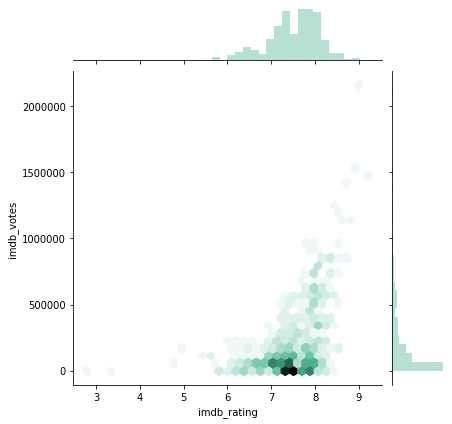

In [73]:
ax = sns.jointplot(movies_complete["imdb_rating"], movies_complete["imdb_votes"], kind="hex", color="#4CB391")

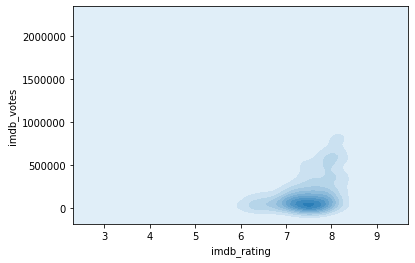

In [41]:
ax = sns.kdeplot(movies_complete["imdb_rating"], movies_complete["imdb_votes"], shade=True)
#ax.set_ylim(10000, 3000000)
#ax.set_yscale("log")

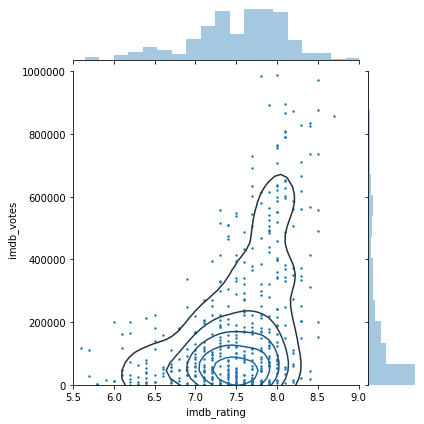

In [42]:
(sns
    .jointplot(
        movies_complete["imdb_rating"],
        movies_complete["imdb_votes"],
        zorder=0,
        xlim=(5.5 ,9),
        ylim=(0, 1000000),
        s=2)
    .plot_joint(
        sns.kdeplot,
        zorder=1,
        n_levels=6)
)

### Korelace

- všeobecný význam
- statistický význam

### Korelace vs. nezávislost

Záludnost souhrnných statistik názorně ukazuje tzv. **[Anscombeho kvartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)**, čtveřice naprosto odlišných datových sad, které všechny sdílejí stejné hodnoty základních statistik (s jistou přesností):

In [43]:
anscombe = pd.read_csv("static/anscombe.csv")
anscombe[:15]

,x,y,data
0,10,8.04,0
1,8,6.95,0
2,13,7.58,0
3,9,8.81,0
4,11,8.33,0
5,14,9.96,0
6,6,7.24,0
7,4,4.26,0
8,12,10.84,0
9,7,4.82,0


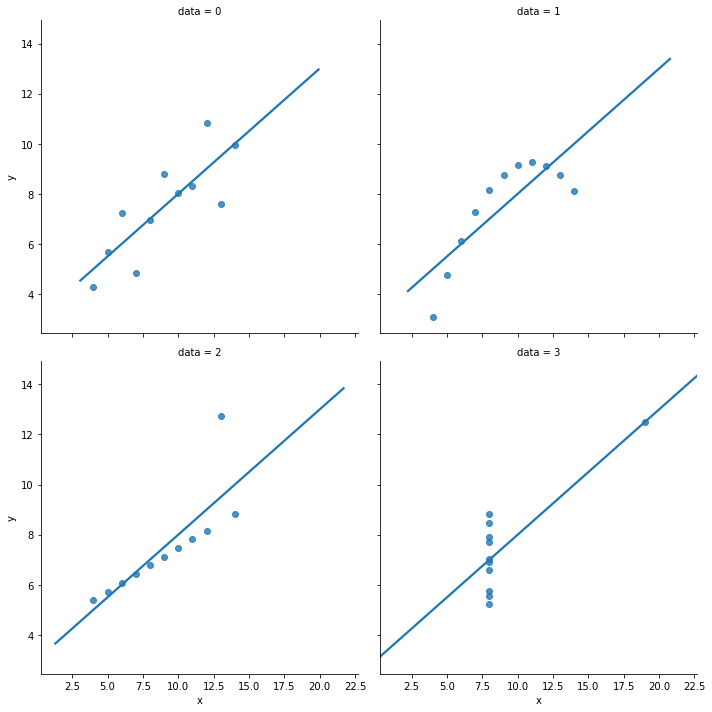

In [44]:
#grid = sns.FacetGrid(
#    anscombe,
#    col="data",
#    col_wrap=2,
#)
sns.lmplot(data=anscombe, col="data", x="x", y="y", ci=None, col_wrap=2)

In [45]:
anscombe[anscombe["data"] == 1].describe()

,x,y,data
count,11.000000,11.000000,11.0
mean,9.000000,7.500909,1.0
std,3.316625,2.031657,0.0
min,4.000000,3.100000,1.0
25%,6.500000,6.695000,1.0
50%,9.000000,8.140000,1.0
75%,11.500000,8.950000,1.0
max,14.000000,9.260000,1.0


In [46]:
anscombe[anscombe["data"] == 0].describe()

,x,y,data
count,11.000000,11.000000,11.0
mean,9.000000,7.500909,0.0
std,3.316625,2.031568,0.0
min,4.000000,4.260000,0.0
25%,6.500000,6.315000,0.0
50%,9.000000,7.580000,0.0
75%,11.500000,8.570000,0.0
max,14.000000,10.840000,0.0


In [47]:
anscombe[anscombe["data"] == 0][["x", "y"]].corr()

,x,y
x,1.000000,0.816421
y,0.816421,1.000000


In [48]:
anscombe[anscombe["data"] == 1][["x", "y"]].corr()

,x,y
x,1.000000,0.816237
y,0.816237,1.000000


Dovedeno do extrému, není vůbec problém nakreslit téměř libovolně vypadající obrázek alias bodový graf, který bude mít dané souhrnné statistiky. V pěkném interaktivním článku [Same Stats, Different Graphs...](https://www.autodeskresearch.com/publications/samestats) autoři ukazují pěkné animace plynulých přechodů mezi sadami, které se chovají podobně jako Anscombeho kvartet.

My si ukážeme aspoň statickou podobu:

In [49]:
# Data nejsou oddělená čárkami, ale tabulátory
datasaurus = pd.read_csv("static/datasaurus_dozen.tsv", delimiter="\t")
datasaurus.sample(10)

,dataset,x,y
1250,circle,52.081756,16.453875
1404,bullseye,50.515960,9.765592
1636,slant_down,54.802683,75.363985
1285,bullseye,39.649574,82.664534
1645,slant_down,66.154005,84.111937
1631,slant_down,62.359766,90.243660
1527,slant_up,63.723184,14.521421
756,star,40.435692,20.232671
373,h_lines,80.240251,70.354309
379,h_lines,98.288123,30.603919


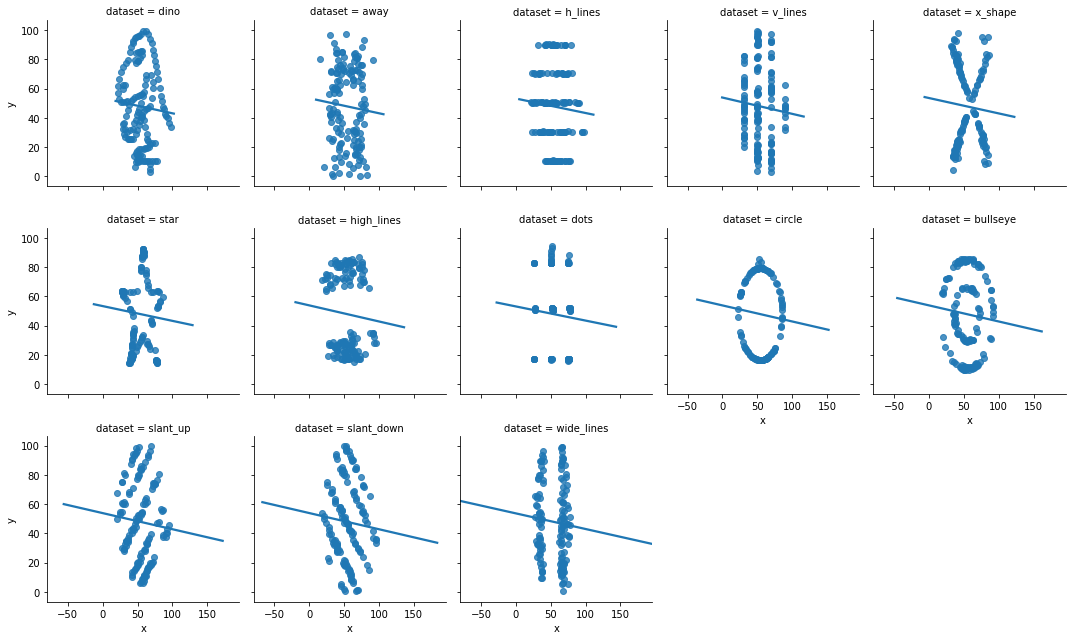

In [50]:
grid = sns.FacetGrid(
    datasaurus,
    col="dataset",
    col_wrap=5,
)
grid.map(sns.regplot, "x", "y", ci=None)

In [51]:
grouper = datasaurus.groupby("dataset")
single = grouper.agg({"x": ("mean", "std"), "y": ("mean", "std")})
correlation = grouper.apply(lambda g: g["x"].corr(g["y"])).rename("pearson_r")
single.join(correlation)

C:\Users\janpi\Miniconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(x, mean)","(x, std)","(y, mean)","(y, std)",pearson_r
dataset,,,,,
away,54.266100,16.769825,47.834721,26.939743,-0.064128
bullseye,54.268730,16.769239,47.830823,26.935727,-0.068586
circle,54.267320,16.760013,47.837717,26.930036,-0.068343
dino,54.263273,16.765142,47.832253,26.935403,-0.064472
dots,54.260303,16.767735,47.839829,26.930192,-0.060341
h_lines,54.261442,16.765898,47.830252,26.939876,-0.061715
high_lines,54.268805,16.766704,47.835450,26.939998,-0.068504
slant_down,54.267849,16.766759,47.835896,26.936105,-0.068980
slant_up,54.265882,16.768853,47.831496,26.938608,-0.068609


Korelační koeficient: -0.06504710815893125


,x,y
count,100.000000,100.000000
mean,54.260000,47.830000
std,16.854484,27.075719
min,14.883170,-12.529292
25%,43.015763,28.576099
50%,53.307941,46.389213
75%,65.586652,69.424172
max,99.541809,112.181136


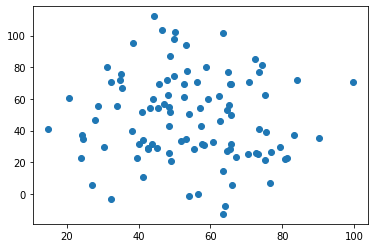

In [52]:
import numpy as np
x = np.random.normal(0, 1, 100)
y = np.random.normal(0, 1, 100)

while True:
    correlation = pd.Series(x).corr(pd.Series(y))
    if correlation < -0.067:
        y = y + (x * 0.001)
    elif correlation > -0.065:
        y = y - (x * 0.001)
    else:
        break
        
x = x * 16.77 / x.std()
x = x + 54.26 - x.mean()

y = y * 26.94 / y.std()
y = y + 47.83 - y.mean()

plt.scatter(x, y)
print("Korelační koeficient:", pd.Series(x).corr(pd.Series(y)))
pd.DataFrame({"x": x, "y": y}).describe()

### Heatmap

## Vztahy mezi více proměnnými

Pokud si tyto materiály nečteš na holografickém displeji, jsi při zobrazování dat omezen/a na dva rozměry. Můžeš si prohlížet dvourozměrné tabulky, kreslit dvourozměrné grafy.

In [53]:
movies_complete[["year", "imdb_rating", "imdb_votes", "tomatoes_rating", "lifetime_gross"]].corr()

,year,imdb_rating,imdb_votes,tomatoes_rating,lifetime_gross
year,1.000000,-0.255125,-0.028770,-0.141083,0.100662
imdb_rating,-0.255125,1.000000,0.481788,0.660791,0.215969
imdb_votes,-0.028770,0.481788,1.000000,0.174733,0.657571
tomatoes_rating,-0.141083,0.660791,0.174733,1.000000,0.085623
lifetime_gross,0.100662,0.215969,0.657571,0.085623,1.000000


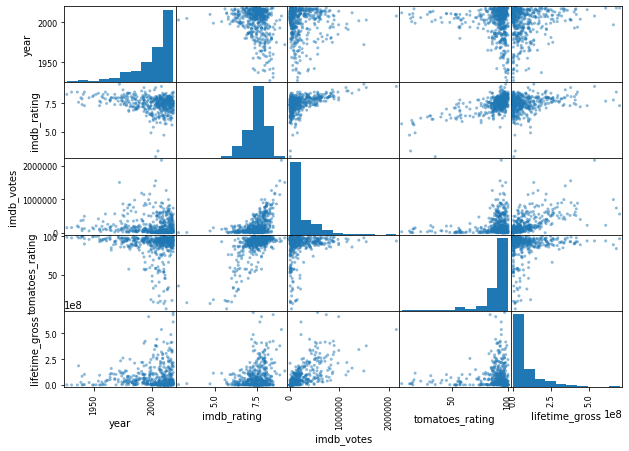

In [69]:
pd.plotting.scatter_matrix(
    movies_complete[["year", "imdb_rating", "imdb_votes", "tomatoes_rating", "lifetime_gross"]],
    figsize=(10, 7)
);

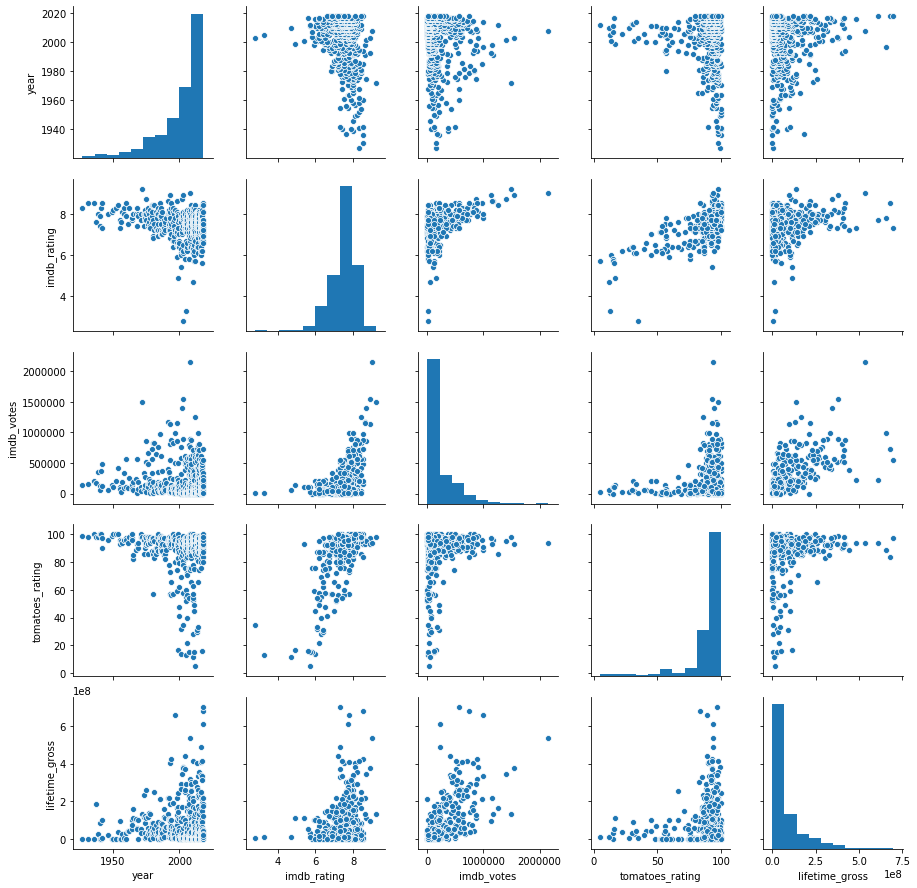

In [54]:
sns.pairplot(movies_complete[["year", "imdb_rating", "imdb_votes", "tomatoes_rating", "lifetime_gross"]])

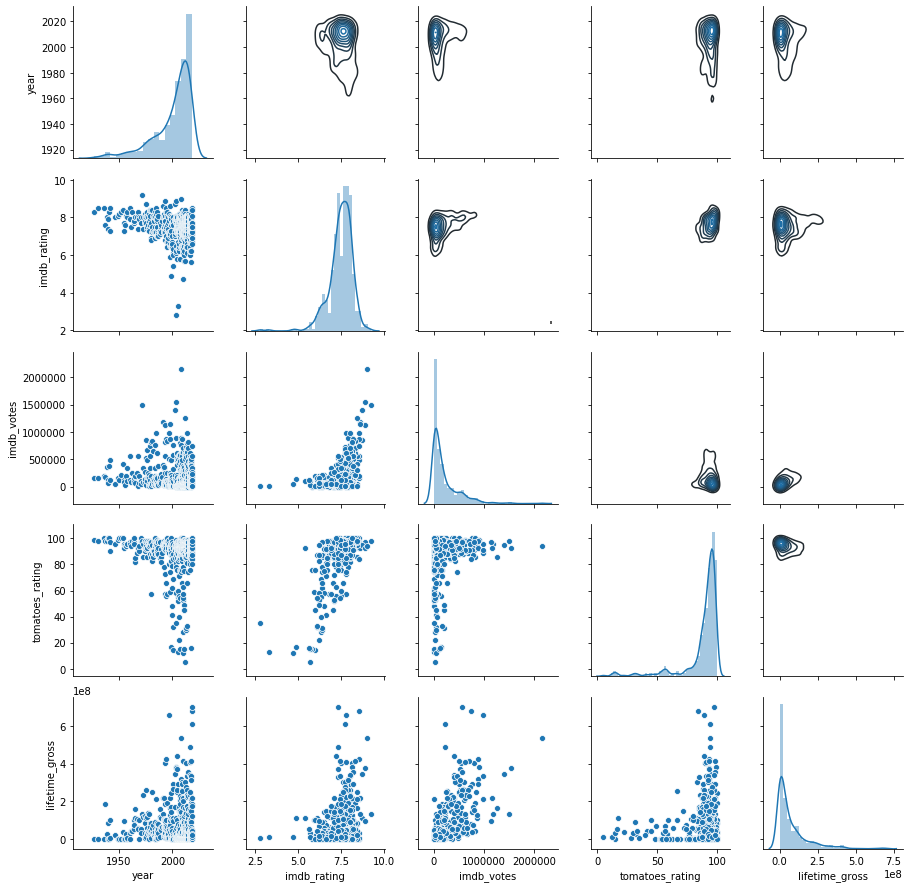

In [55]:
# pairplot
g = sns.PairGrid(
    movies_complete[["year", "imdb_rating", "imdb_votes", "tomatoes_rating", "lifetime_gross"]], 
    diag_sharey=False,
)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, hist=True, kde=True);

In [56]:
# catplot

### 3D grafy

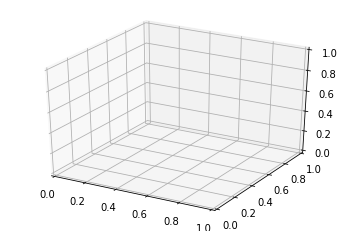

In [57]:
# 3D grafy
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

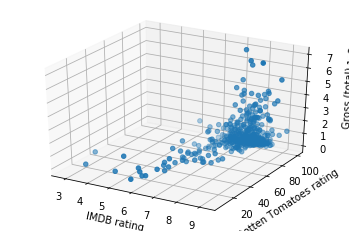

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    movies_complete["lifetime_gross"])
ax.set_xlabel("IMDB rating")
ax.set_ylabel("Rotten Tomatoes rating")
ax.set_zlabel("Gross (total)");

In [59]:
%matplotlib qt

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    movies_complete["lifetime_gross"],
)
ax.set_xlabel("IMDB rating")
ax.set_ylabel("Rotten Tomatoes rating")
ax.set_zlabel("Gross (total)");
fig.show()

Nutno podotknout, že na kreslení 3D grafů, zejména uvnitř notebooku, je užitečnější použít `plotly` (resp. `plotly.express`):

In [63]:
import plotly.express as px
df = px.data.election()
fig = px.scatter_3d(movies_complete, x="imdb_rating", y="tomatoes_rating", z="lifetime_gross", hover_name="title")
fig.show()